In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read the two datasets
orders = pd.read_csv('data/Orders.csv')
returns = pd.read_csv('data/Returns.csv')

# Problem 1: Dataset Import & Cleaning
Check **"Profit"** and **"Sales"** in the dataset, convert these two columns to numeric type.  

In [3]:
# remove periods from orders column names
orders.columns=orders.columns.str.replace('.','_')
# remove spaces from region column names
returns.columns=returns.columns.str.replace(' ','_')

In [4]:
orders.Profit = orders.Profit.apply(lambda s: float(s.replace("$","").replace(',','')))
orders.Sales = orders.Sales.apply(lambda s: float(s.replace("$","").replace(',','')))

In [5]:
# How much data is there?
print("Orders dimensions:", orders.shape,"\n")
# How many null values are there - we see that there are 41,296 missing postcodes
print("Missing values:\n",orders.isnull().sum())

Orders dimensions: (51290, 24) 

Missing values:
 Row_ID                0
Order_ID              0
Order_Date            0
Ship_Date             0
Ship_Mode             0
Customer_ID           0
Customer_Name         0
Segment               0
Postal_Code       41296
City                  0
State                 0
Country               0
Region                0
Market                0
Product_ID            0
Category              0
Sub_Category          0
Product_Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping_Cost         0
Order_Priority        0
dtype: int64


In [6]:
orders.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Postal_Code,City,...,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit,Shipping_Cost,Order_Priority
0,40098,CA-2014-AB10015140-41954,11/11/14,11/13/14,First Class,AB-100151402,Aaron Bergman,Consumer,73120.0,Oklahoma City,...,TEC-PH-5816,Technology,Phones,Samsung Convoy 3,221.98,2,0.0,62.15,40.77,High
1,26341,IN-2014-JR162107-41675,2/5/14,2/7/14,Second Class,JR-162107,Justin Ritter,Corporate,NaN,Wollongong,...,FUR-CH-5379,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.40,9,0.1,-288.77,923.63,Critical
2,25330,IN-2014-CR127307-41929,10/17/14,10/18/14,First Class,CR-127307,Craig Reiter,Consumer,NaN,Brisbane,...,TEC-PH-5356,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.17,9,0.1,919.97,915.49,Medium
3,13524,ES-2014-KM1637548-41667,1/28/14,1/30/14,First Class,KM-1637548,Katherine Murray,Home Office,NaN,Berlin,...,TEC-PH-5267,Technology,Phones,"Motorola Smart Phone, Cordless",2892.51,5,0.1,-96.54,910.16,Medium
4,47221,SG-2014-RH9495111-41948,11/5/14,11/6/14,Same Day,RH-9495111,Rick Hansen,Consumer,NaN,Dakar,...,TEC-CO-6011,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.96,8,0.0,311.52,903.04,Critical


In [7]:
returns.head()

,Returned,Order_ID,Region
0,Yes,CA-2012-SA20830140-41210,Central US
1,Yes,IN-2012-PB19210127-41259,Eastern Asia
2,Yes,CA-2012-SC20095140-41174,Central US
3,Yes,IN-2015-JH158207-42140,Oceania
4,Yes,IN-2014-LC168857-41747,Oceania


# Problem 2: Inventory Management
- Retailers that depend on seasonal shoppers have a particularly challenging job when it comes to 
  inventory management. Your manager is making plans for next year's inventory.
- He wants you to answer the following questions:
    1. Is there any seasonal trend of inventory in the company?
    2. Is the seasonal trend the same for different categories?

In [8]:
# Plot inventory over time
orders.Order_Date.apply(type)[:1]

# First convert Order_Date to type datetime
orders.Order_Date = pd.to_datetime(orders.Order_Date)

# What range of time is covered?
print("Start: %s" % max(orders.Order_Date))
print("End: %s" % min(orders.Order_Date))

Start: 2015-12-31 00:00:00
End: 2012-01-01 00:00:00


In [9]:
# Get a sum of orders per day
quantity_by_date = orders[["Order_Date","Quantity"]].groupby(["Order_Date"]).sum()
quantity_by_date = quantity_by_date.groupby(pd.Grouper(freq="M")).sum()
quantity_by_date.head()

,Quantity
Order_Date,
2012-01-31,1463
2012-02-29,1401
2012-03-31,1745
2012-04-30,1934
2012-05-31,2167


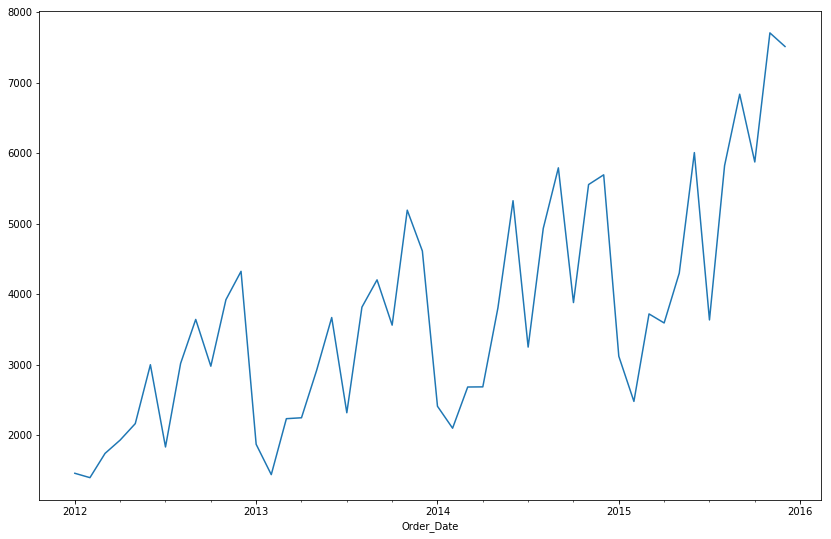

In [10]:
# PLOT!
# quantity_by_date.plot() # works but ugly
plt.rcParams['figure.figsize'] = 14, 9
quantity_by_date.Quantity.plot(kind='line')
# Add title and axes

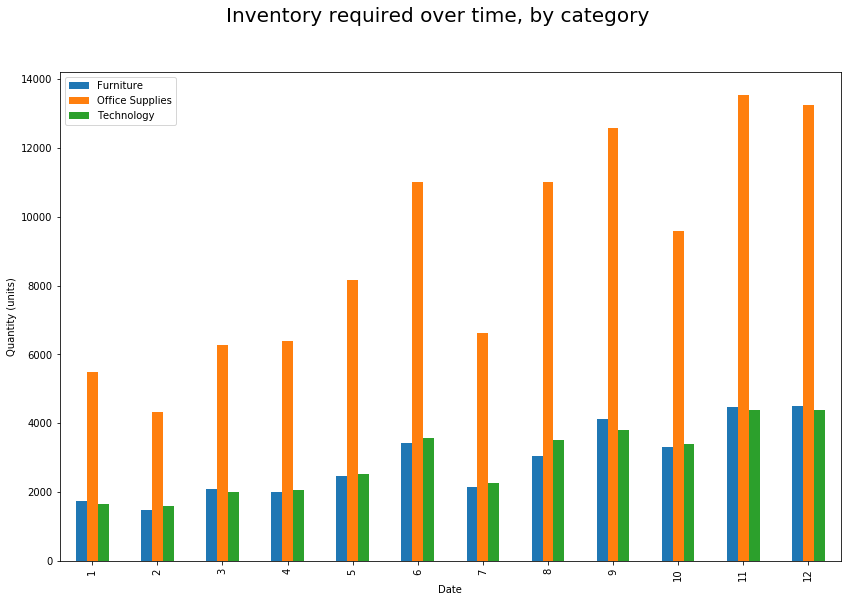

In [11]:
# Also group by category
quant_cat = orders[["Category","Order_Date","Quantity"]].groupby(["Order_Date","Category"]).sum()
quant_cat = quant_cat.reset_index(level=["Category"])
quant_cat_plot = quant_cat.groupby([quant_cat.index.month, 'Category']).sum().unstack(fill_value=0).plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Quantity (units)')
plt.suptitle('Inventory required over time, by category', fontsize=20)
L=plt.legend()
L.get_texts()[0].set_text('Furniture')
L.get_texts()[1].set_text('Office Supplies')
L.get_texts()[2].set_text('Technology')

### Seasonal trends
It appears that orders spike in the start of summer(June), start of the school year (August, September), and Holiday season (November, December).

# Problem 3: Why did customers make returns?
Your manager required you to give a brief report (**Plots + Interpretations**) on returned orders.

1. How much profit did we lose due to returns each year?
2. How many customer returned more than once? more than 5 times?
3. Which regions are more likely to return orders?
4. Which categories (sub-categories) of products are more likely to be returned?

***Hint:*** Merge the **Returns** dataframe with the **Orders** dataframe using `Order.ID`.

In [12]:
# How much profit was lost to returns?
# Add returned column to orders
r2 = returns.drop(columns="Region")
merged = orders.merge(r2,left_on="Order_ID", right_on="Order_ID", how="left")
# Replace NaN with "No"
merged.Returned = merged.Returned.replace(np.nan, 'No', regex=True)
merged.Returned.unique()

# Get the profit returned and not returned
merged['Year'] = merged.Order_Date.apply(lambda d: d.year)
merged2 = merged[["Year","Returned","Profit"]].groupby(["Year","Returned"]).sum()
merged2 = merged2.reset_index(level=["Returned"])
# merged2

In [13]:
# To view as pcts, get the total profit
total_profit = merged2.groupby("Year").sum()
total_profit=total_profit.rename(columns = {'Profit':'Year_Total_Profit'})

# total_profit
merged3 = merged2.merge(total_profit,left_on="Year", right_on="Year", how="left")
merged3["Pct_Year_Total_Profit"] = merged3.Profit / merged3.Year_Total_Profit * 100
# merged3

In [14]:
# Profits lost each year
# merged3.loc[merged3.Returned=="Yes"].iloc[:,[0,2,3]]

In [15]:
# How many customers returned an item more than once?
repeat_off = merged.loc[(merged.Returned=="Yes")].groupby("Customer_ID").size()
repeat_off[repeat_off > 1].size

547

In [16]:
# Made more than 5 returns
repeat_off[repeat_off > 5].size

46

In [17]:
# Which regions are more likely to return orders
ret = merged[["Region","Returned","Order_ID"]].groupby(["Region","Returned"]).count()
ret = ret.reset_index(level=["Returned"])
ret = ret.rename(columns = {"Order_ID":"Order_Count"})

total_ret = ret.groupby("Region").sum()
total_ret=total_ret.rename(columns = {'Order_Count':'Total_Orders'})

ret = ret.merge(total_ret,left_on="Region", right_on="Region", how="left")
ret = ret.loc[ret.Returned == "Yes"]
ret = ret.rename(columns = {"Order_Count":"Returned_Orders"})
ret["Pct_Returned"] = ret.Returned_Orders / ret.Total_Orders * 100
# ret.iloc[:,1:4].sort_values(by="Pct_Returned", ascending = False)

In [18]:
# Which categories (sub-categories) of products are more likely to be return
ret_cat = merged[["Category","Returned","Order_ID"]].groupby(["Category","Returned"]).count()
ret_cat = ret_cat.reset_index(level=["Returned"])
ret_cat = ret_cat.rename(columns = {"Order_ID":"Order_Count"})

total_ret_cat = ret_cat.groupby("Category").sum()
total_ret_cat = total_ret_cat.rename(columns = {'Order_Count':'Total_Orders'})
total_ret_cat

ret_cat = ret_cat.merge(total_ret_cat,left_on="Category", right_on="Category", how="left")
ret_cat = ret_cat.loc[ret_cat.Returned == "Yes"]
ret_cat = ret_cat.rename(columns = {"Order_Count":"Returned_Orders"})
ret_cat["Pct_Returned"] = ret_cat.Returned_Orders / ret_cat.Total_Orders * 100
# ret_cat.iloc[:,1:4].sort_values(by="Pct_Returned", ascending = False)

## Problem 3 Summary

### Profits lost each year

In [19]:
merged3.loc[merged3.Returned=="Yes"].iloc[:,[0,2,3]]

,Returned,Year_Total_Profit,Pct_Year_Total_Profit
Year,,,
2012,Yes,248940.35,7.020662
2013,Yes,307415.33,3.015429
2014,Yes,406934.89,4.303054
2015,Yes,504166.10,3.394312


### Customer Returns

* 547 customers returned more than once
* 46  customers returned more than 5x

### Returns by Region

* The Western US, Eastern Asia, Southern Europe, Southern Africa, and Southern US are the top 5 most likely regions to return.  All had a return percentage of greater than 5%.

In [20]:
ret.iloc[:,1:4].sort_values(by="Pct_Returned", ascending = False)

,Returned_Orders,Total_Orders,Pct_Returned
Region,,,
Western US,177,3203,5.526069
Eastern Asia,131,2374,5.518113
Southern Europe,112,2113,5.300521
Southern Africa,25,478,5.230126
Southern US,83,1620,5.123457
Eastern US,134,2848,4.705056
Southeastern Asia,140,3129,4.474273
South America,133,2988,4.451138
Western Asia,108,2440,4.426230


### Returns by Category

The three categories were equally likely to be returned.

In [21]:
ret_cat.iloc[:,1:4].sort_values(by="Pct_Returned", ascending = False)

,Returned_Orders,Total_Orders,Pct_Returned
Category,,,
Technology,445,10141,4.388127
Furniture,427,9860,4.330629
Office Supplies,1348,31289,4.308223
